### 1. Import Module

In [90]:
import torch
import torch.nn as nn
import pandas as pd
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### 2. Load Dataset

In [3]:
path = "C:/Users/62812/Documents/Kuliah/Semester 3/Github/Image Regocnition Using VGG from scratch/Dataset/"
df_dataset = pd.read_csv(path+'sports.csv')
df_dataset.head(5)

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [4]:
#check data type of each column
df_dataset.dtypes

class id      int64
filepaths    object
labels       object
data set     object
dtype: object

In [5]:
import torch

# Assuming you have a list of tensors
tensor_list = [torch.randn(3, 224, 224), torch.randn(3, 224, 224), torch.randn(3, 224, 224)]

# Concatenating the list of tensors along a new dimension (dimension 0)
concatenated_tensor = torch.stack(tensor_list, dim=0)

# Printing the shape of the concatenated tensor
print(concatenated_tensor.shape)


torch.Size([3, 3, 224, 224])


In [18]:
image_size = 224
transform_image = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])

def create_data_tensor(df_dataset, transform_image, path):
    #total number of class in dataset
    total_class = len(df_dataset['class id'].unique())
    X = {}
    y = {}
    labels = {}
    error_file = []
    for class_id, filepaths, label, dataset in  df_dataset.itertuples(index=False):
        try:
            img = Image.open(path+filepaths)
            img_transformed = transform_image(img)
            label_tensor = torch.zeros(100)
            label_tensor[class_id] = 1

            #check if the dataset type already in our dict 
            if dataset in X:
                X[dataset].append(img_transformed)
                y[dataset].append(label_tensor)
                labels[dataset].append(label)

            else:
                X[dataset] = [img_transformed]
                y[dataset] = [label_tensor]
                labels[dataset] = [label]
        except:
             error_file.append(filepaths)
    return X,y,labels,error_file

In [19]:
X,y,labels,error_file = create_data_tensor(df_dataset, transform_image, path)

In [25]:
X_train, y_train = torch.stack(X['train'], dim=0), torch.stack(y['train'], dim=0) 
X_val, y_val = torch.stack(X['valid'], dim=0), torch.stack(y['valid'], dim=0) 
X_test, y_test = torch.stack(X['test'], dim=0), torch.stack(y['test'], dim=0)

In [55]:
from torch.utils.data import Dataset

class Sports(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = Sports(X_train, y_train)
val_dataset = Sports(X_val, y_val)
test_dataset = Sports(X_test, y_test)

In [56]:
from torch.utils.data import DataLoader
batch_size= 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

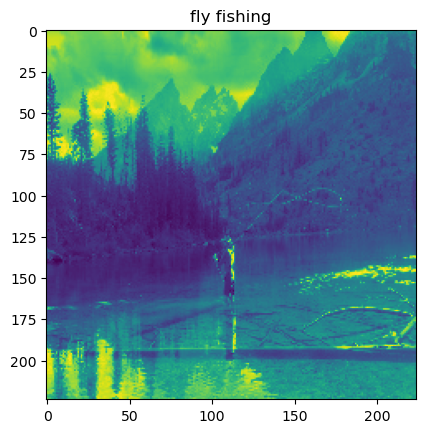

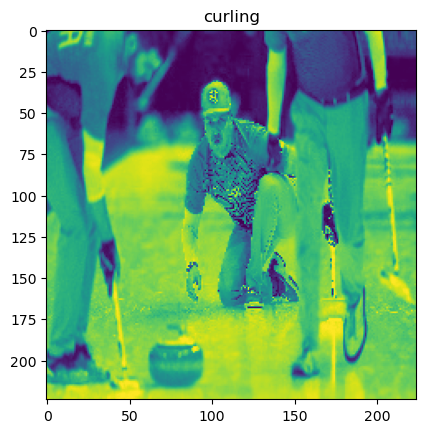

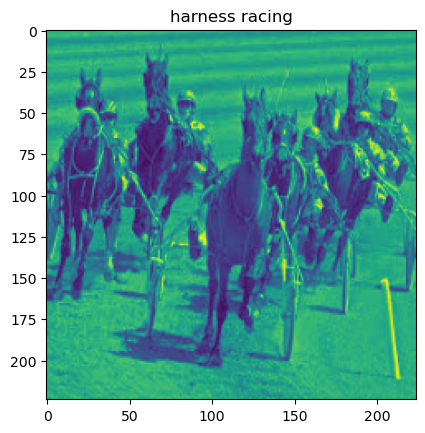

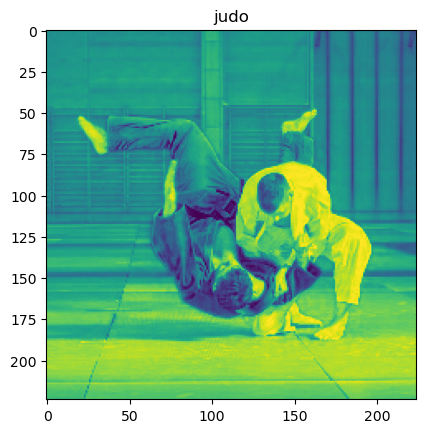

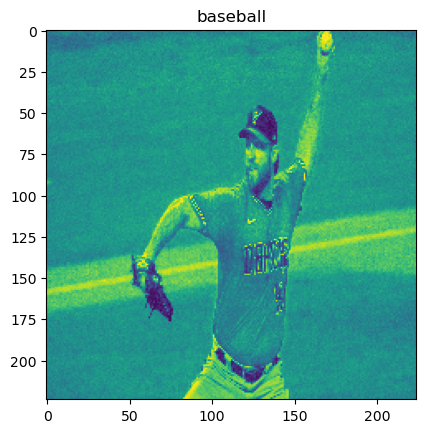

In [79]:
for t in range(5):
    plt.imshow(x[t][0].numpy())
    plt.title(df_dataset['labels'].unique()[int(np.argmax(y[t]))])
    plt.show()

### 3. Create Model VGG

In [80]:
#Define all VGG type
VGG_version = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
               'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
               'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512 ,512, 'M'],
               'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512 ,512, 512, 'M']
                }

In [81]:
class VGG_net(nn.Module):
    def __init__(self, conv_layers, in_channels = 3, num_classes = 100):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(conv_layers)
        self.fc = nn.Sequential(nn.Linear(512*7*7, 4096),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(4096,4096),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(4096,num_classes))
    
    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for layer in architecture:
            if type(layer) == int:
                out_channels = layer
                layers+=(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                                        kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                                        nn.BatchNorm2d(layer),
                                        nn.ReLU())
                in_channels = layer
            elif layer == 'M':
                layers.append(nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x                       

In [82]:
version_of_VGG = 'VGG11'
num_classes = len(df_dataset['class id'].unique())
model = VGG_net(conv_layers = VGG_version[version_of_VGG],in_channels = 3, num_classes = num_classes).to(device)
x = torch.rand(1,3,224,224).to(device)
output = model(X_train[0:2].to(device))
print(output.shape)

torch.Size([2, 100])


In [83]:
print(f"This is a summary of {version_of_VGG} model:")
summary(model,X_train.shape[-3:])

This is a summary of VGG11 model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
     

In [93]:
def train(model, dataloader, criterion, optimizer, epochs, device):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        for btc_index, (X,y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            
            #forward pass
            output = model(X)
            
            #calculate loss
            loss = criterion (output,y)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs} with loss {loss.item():.4f}")
        
    return model,train_loss

In [94]:
#set SEED number, so we will get the same output when running with same parameters
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

lr = 0.001
criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model.to(device)

t_start = time.time()
model,train_loss = train(model, train_loader, criterion, optimizer, epochs, device)
t_end = time.time()
print(f"Waktu running {NUM_EPOCHS} menggunakan {device} yaitu {t_end - t_start} detik")

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 6.00 GiB total capacity; 5.21 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF